## Описание проекта


Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

Необходимо определяющие успешность игры закономерности.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Общее

## Описание данных

+ `Name` — название игры
+ `Platform` — платформа
+ `Year_of_Release` — год выпуска
+ `Genre` — жанр игры
+ `NA_sales` — продажи в Северной Америке (миллионы долларов)
+ `EU_sales` — продажи в Европе (миллионы долларов)
+ `JP_sales` — продажи в Японии (миллионы долларов)
+ `Other_sales` — продажи в других странах (миллионы долларов)
+ `Critic_Score` — оценка критиков (максимум 100)
+ `User_Score` — оценка пользователей (максимум 10)
+ `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

## Импортируем библиотеки

In [1]:
# Импортируем библиотеки
# для работы с данными
import pandas as pd
import numpy as np

# для работы с датой
import datetime
from dateutil import relativedelta

# Для работы со статистикой
from scipy import stats as st

#Предупреждения
import warnings
warnings.filterwarnings('ignore')

#для загрузки данных
from pathlib import Path
import os
import urllib.request

# Для Графиков
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

#Для обработки строк
import re

# 1. Изучим общую информацию

## Описание шага

In [2]:
#Cоздадим папку если ее нет
Path('datasets').mkdir(parents=True, exist_ok=True)

def get_file(file_name, url):
    #Проверим есть ли файл
    if not os.path.exists(file_name):
        print(file_name, 'файл не найден, будет загружен из сети')
        #качаем файл по ссылке url, кладем по пути file_name
        _ = urllib.request.urlretrieve(url, file_name)
    
#словарь с именем файла и ссылкой на него
urls = {
    'games': ('datasets/games.csv', '.../datasets/games.csv'),
}

[get_file(*urls[k]) for k in urls]
 
data =  pd.read_csv(urls['games'][0])

In [3]:
#Постомтир первые 10 строк 
data.head(10).style.set_caption('Первые 10 строк таблицы')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.000000,Sports,41.360000,28.960000,3.770000,8.450000,76.000000,8,E
1,Super Mario Bros.,NES,1985.000000,Platform,29.080000,3.580000,6.810000,0.770000,nan,nan,nan
2,Mario Kart Wii,Wii,2008.000000,Racing,15.680000,12.760000,3.790000,3.290000,82.000000,8.3,E
3,Wii Sports Resort,Wii,2009.000000,Sports,15.610000,10.930000,3.280000,2.950000,80.000000,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.000000,Role-Playing,11.270000,8.890000,10.220000,1.000000,nan,nan,nan
5,Tetris,GB,1989.000000,Puzzle,23.200000,2.260000,4.220000,0.580000,nan,nan,nan
6,New Super Mario Bros.,DS,2006.000000,Platform,11.280000,9.140000,6.500000,2.880000,89.000000,8.5,E
7,Wii Play,Wii,2006.000000,Misc,13.960000,9.180000,2.930000,2.840000,58.000000,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.000000,Platform,14.440000,6.940000,4.700000,2.240000,87.000000,8.4,E
9,Duck Hunt,NES,1984.000000,Shooter,26.930000,0.630000,0.280000,0.470000,nan,nan,nan


In [4]:
#Посмотрим основную информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
#Постомтрим основные метрики категориальных данных
data.describe(include=['object'])

,Name,Platform,Genre,User_Score,Rating
count,16713,16715,16713,10014,9949
unique,11559,31,12,96,8
top,Need for Speed: Most Wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


In [6]:
#Настроим отображение
pd.options.display.float_format = '{:,.2f}'.format
data.describe(percentiles=[.05, .25, .5, .75, 0.95])

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,"16,446.00","16,715.00","16,715.00","16,715.00","16,715.00","8,137.00"
mean,"2,006.48",0.26,0.15,0.08,0.05,68.97
std,5.88,0.81,0.50,0.31,0.19,13.94
min,"1,980.00",0.00,0.00,0.00,0.00,13.00
5%,"1,996.00",0.00,0.00,0.00,0.00,43.00
25%,"2,003.00",0.00,0.00,0.00,0.00,60.00
50%,"2,007.00",0.08,0.02,0.00,0.01,71.00
75%,"2,010.00",0.24,0.11,0.04,0.03,79.00
95%,"2,015.00",1.06,0.62,0.36,0.20,89.00
max,"2,016.00",41.36,28.96,10.22,10.57,98.00


In [7]:
#проверим пропуски
(data.isnull().sum().sort_values(ascending=False) / len(data)).apply(lambda x: '{:.2%}'.format(x))

Critic_Score       51.32%
Rating             40.48%
User_Score         40.09%
Year_of_Release     1.61%
Genre               0.01%
Name                0.01%
Other_sales         0.00%
JP_sales            0.00%
EU_sales            0.00%
NA_sales            0.00%
Platform            0.00%
dtype: object

In [8]:
#Проверим дубликаты
data.duplicated().sum()

0

## Вывод

1. Наименование колонок содержат верхний регистр - перевести в нижний
2. Целочисленным анным соответствует тип float - изменить тип
3. Колонка `User_Score` имеет смысл количественных данных, но указана как категориальная - ищменить тип
4. Достаточно много нулевых значений в колонках о продажах по регионам - проверить
5. Наиболее встречающиеяся название\платформа\жанр - Need for Speed: Most Wanted\ PS2 \ Action
6. Дубликатов не обнаружено, требуется произвести учет регистра и проверить еще раз (в следующем шаге)
7. Имеются пропуски в колонках:
 + `Critic_Score`      - 51.32%
 + `Rating`            - 40.48%`
 + `User_Score`        - 40.09%
 + `Year_of_Release`   - 1.61%
 + `Genre` и `Name` по - 0.01%

# 2. Подготовка данных

## Описание шага

In [9]:
#Изменим регистр названия колонок на нижний
data.columns = data.columns.str.lower()

## Проверим наличие дубликатов
Проверим уникальные значения в колонках `name`, `rating`, `genre` и `platform` при текущем регистре и нижнем

In [10]:
_cols = ['name', 'rating', 'genre', 'platform']
for col in _cols:
    if len(data[col].unique()) != len(data[col].str.lower().unique()):
        print('Похоже в колонке "{}" есть дубликаты, нужно проверять'.format(col))
    else:
        print('Дубликатов в колонке "{}", свзанных с регистром не обнаружено'.format(col))

Дубликатов в колонке "name", свзанных с регистром не обнаружено
Дубликатов в колонке "rating", свзанных с регистром не обнаружено
Дубликатов в колонке "genre", свзанных с регистром не обнаружено
Дубликатов в колонке "platform", свзанных с регистром не обнаружено


## Поиск ошибок

При выполнении метода `describe()` было обнаружено большое количество нулевых значений, вплоть до 50% от общего количества значений, т.к. в данных колонках размерность в M$, то возможно продаж было очень мало и метод округлил, отбросив значения.

Проверим пересчитав из милл долл в долл

In [11]:
#домножим значения на 1000000, чтобы получить в $
_cols = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
(data[_cols] * 1000000).describe(percentiles=[.05, .25, .5, .75, 0.95])

,na_sales,eu_sales,jp_sales,other_sales
count,"16,715.00","16,715.00","16,715.00","16,715.00"
mean,"263,377.21","145,059.53","77,617.11","47,341.91"
std,"813,603.52","503,338.51","308,853.43","186,731.04"
min,0.00,0.00,0.00,0.00
5%,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,"80,000.00","20,000.00",0.00,"10,000.00"
75%,"240,000.00","110,000.00","40,000.00","30,000.00"
95%,"1,060,000.00","620,000.00","360,000.00","200,000.00"
max,"41,360,000.00","28,960,000.00","10,220,000.00","10,570,000.00"


Как видно нулевые значения сохранились, скорее всего это связано с тем, что часть игр не продавалась в перечисленных регионах

## Обработка пропусков

### `name` and `genre`

In [12]:
#посмотрим что за пропуски
data.loc[data.name.isnull()]#Пропуски взаимосвязаны

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,"1,993.00",NaN,1.78,0.53,0.00,0.08,nan,NaN,NaN
14244,NaN,GEN,"1,993.00",NaN,0.00,0.00,0.03,0.00,nan,NaN,NaN


Т.к. по имеющейся информации восстановить пропуски не представляется возможным, заменим пропуски на `unknown`

In [13]:
data.loc[data.name.isnull(), ['name', 'genre']] = 'unknown'

### `year_of_release`

In [14]:
#посмотрим что за пропуски
data.loc[data.year_of_release.isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,nan,Sports,4.26,0.26,0.01,0.71,94.00,8.5,E
377,FIFA Soccer 2004,PS2,nan,Sports,0.59,2.36,0.04,0.51,84.00,6.4,E
456,LEGO Batman: The Videogame,Wii,nan,Action,1.80,0.97,0.00,0.29,74.00,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,nan,Fighting,1.57,1.02,0.00,0.41,nan,NaN,NaN
609,Space Invaders,2600,nan,Shooter,2.36,0.14,0.00,0.03,nan,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,nan,Sports,0.01,0.00,0.00,0.00,43.00,tbd,E10+
16405,Freaky Flyers,GC,nan,Racing,0.01,0.00,0.00,0.00,69.00,6.5,T
16448,Inversion,PC,nan,Shooter,0.01,0.00,0.00,0.00,59.00,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,nan,Adventure,0.01,0.00,0.00,0.00,nan,NaN,NaN


In [15]:
data.loc[data.year_of_release.isnull()].isnull().sum()

name                 0
platform             0
year_of_release    269
genre                0
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score       115
user_score          94
rating              88
dtype: int64

In [16]:
len(data.loc[data.year_of_release.isnull(), 'name'].unique()) #для каких-то игр пропуски повторяются

232

Выведем данные о релизах для первых пяти игр из полученной таблицы

In [17]:
_cols = ['name', 'platform', 'year_of_release', 'genre']
_list_of_games = data.loc[data.year_of_release.isnull(), 'name']
[display(data.loc[data.name == game, _cols]) for game in _list_of_games.iloc[:5]]

,name,platform,year_of_release,genre
183,Madden NFL 2004,PS2,nan,Sports
1881,Madden NFL 2004,XB,"2,003.00",Sports
3889,Madden NFL 2004,GC,"2,003.00",Sports
5708,Madden NFL 2004,GBA,"2,003.00",Sports


,name,platform,year_of_release,genre
377,FIFA Soccer 2004,PS2,nan,Sports
2606,FIFA Soccer 2004,XB,"2,003.00",Sports
12029,FIFA Soccer 2004,GC,"2,003.00",Sports
13086,FIFA Soccer 2004,GBA,"2,003.00",Sports


,name,platform,year_of_release,genre
397,LEGO Batman: The Videogame,X360,"2,008.00",Action
456,LEGO Batman: The Videogame,Wii,nan,Action
460,LEGO Batman: The Videogame,DS,"2,008.00",Action
1519,LEGO Batman: The Videogame,PS3,"2,008.00",Action
1538,LEGO Batman: The Videogame,PSP,nan,Action
1553,LEGO Batman: The Videogame,PS2,"2,008.00",Action
12465,LEGO Batman: The Videogame,PC,"2,008.00",Action


,name,platform,year_of_release,genre
475,wwe Smackdown vs. Raw 2006,PS2,nan,Fighting


,name,platform,year_of_release,genre
609,Space Invaders,2600,nan,Shooter
4264,Space Invaders,SNES,"1,994.00",Shooter
8580,Space Invaders,N64,"1,999.00",Shooter
10383,Space Invaders,GBA,"2,002.00",Shooter


[None, None, None, None, None]

как видно большинство игр для разных платформ имеет один год релиза, исключение составляют некоторые игры чьи релизы были в разных годах, проверим эти данные

In [18]:
#Создадим запрос в качестве переменной
query_year_release_wo_na = data['year_of_release'].notnull()
#Число уникальных значений 'name' у которых имеются значения релизов для других платформ
number_of_unique_rows_wo_year_nan = (
    len(data
        .query('name in @_list_of_games & @query_year_release_wo_na')
        ['name']
        .unique()
       )
)
#Число уникальных значений 'name' у которых присутствуют пропуски в 'year_of_release'
number_of_unique_rows_with_year_nan = len(data.loc[data.year_of_release.isnull(), 'name'].unique())

print('Только для {} игр с пропусками из {} есть даты релиза'
       .format(number_of_unique_rows_wo_year_nan,
          number_of_unique_rows_with_year_nan)
) 

Только для 99 игр с пропусками из 232 есть даты релиза


In [19]:
#Создадим запрос в качестве переменной
games_wo_na_in_year_rel = (
    data.query('name in @_list_of_games & @query_year_release_wo_na')[['name', 'year_of_release']]
)
#Сгруппируем по имени и найдем дисперсию, чтобы понимать
#на сколько отличаются даты релизов для различных платформ
var_grouped_by_name_for_dict = games_wo_na_in_year_rel.groupby('name').var().reset_index()
var_grouped_by_name_for_dict

,name,year_of_release
0,AKB1/48: Idol to Guam de Koishitara...,nan
1,Aquaman: Battle for Atlantis,nan
2,Battle vs. Chess,nan
3,Bejeweled 3,nan
4,BioShock 2,0.00
...,...,...
94,WRC: FIA World Rally Championship,nan
95,Wet,nan
96,Wheel of Fortune,52.25
97,Without Warning,nan


1) В данном таблице:
+ nan - если из дат релиза известно значение только для одной платформы 
+ 0 - если значения релизов не отличаются
+ больше 0 - отличаются

первые 2 пункта пример для замены пропусков, 3-й проверим

2) Заменим nan на 0 т.к. nan-соответствует, что в датах релиза известна только одна цифра
Известное значение Примем в качесве замены пропусков для основной таблицы

In [20]:
var_grouped_by_name_for_dict.fillna(0, inplace=True)
var_grouped_by_name_for_dict

,name,year_of_release
0,AKB1/48: Idol to Guam de Koishitara...,0.00
1,Aquaman: Battle for Atlantis,0.00
2,Battle vs. Chess,0.00
3,Bejeweled 3,0.00
4,BioShock 2,0.00
...,...,...
94,WRC: FIA World Rally Championship,0.00
95,Wet,0.00
96,Wheel of Fortune,52.25
97,Without Warning,0.00


In [21]:
#Проверим для 
var_grouped_by_name_for_dict.query('year_of_release > 0')

,name,year_of_release
10,College Hoops 2K6,0.50
28,Hitman 2: Silent Assassin,0.50
45,Mario Tennis,33.33
55,Namco Museum,0.33
59,PES 2009: Pro Evolution Soccer,0.25
61,Rayman Arena,0.50
73,Smashing Drive,2.00
74,Sonic the Hedgehog,75.00
75,Space Invaders,16.33
88,Tom and Jerry in War of the Whiskers,0.50


Для игр со значением дисперсии не более 2 (максимум 1-2 года, для остальных меньше) даты выхода не сильно отличаются, можно принять значения известных релизов для замены пропусков в датах соответствующих игр на других платформах

In [22]:
# Создадим список интересующих нас игр
name_list_for_replace = var_grouped_by_name_for_dict.query('year_of_release <= 2')['name']
#Cоздадим словарь: cгруппируем этот список по 'name', выберем 1-е значение релиза
dict_for_release_replace = (
    data
    .query('name in @name_list_for_replace')[['name', 'year_of_release']]
    .groupby('name')
    .first()
    .to_dict()
)
dict_for_release_replace = dict_for_release_replace.get('year_of_release')

In [23]:
data['year_of_release'] = data['year_of_release'].fillna(data['name'].map(dict_for_release_replace))

Также отметим, что в названии игр встречаются названия года, например "Football Manager 2007" скорее всего соответствует 2007 году.

Выделим цифры и создадим аналогичный словарь, так же могут встречаться цифры в названии не соответствующие году, поэтому отфильтруем по годам нашей выборки 1980<= значение <=2016

In [24]:
#Создадим таблицу с группировкой по именам игр, для которых отсутствует год релиза
other_date_with_na_release = (
    data.loc[data.year_of_release.isnull(), ['name', 'year_of_release']]
    .groupby('name')
    .count()
    .reset_index()
)
#выделим цифры при помощи метода .str.extract() и добавим их в качестве столбца
other_date_with_na_release = (
    other_date_with_na_release.join(other_date_with_na_release['name'].str.extract(r'(?P<digits>\d+)', expand=True))
)
other_date_with_na_release.digits = pd.to_numeric(other_date_with_na_release.digits)

In [25]:
#Cоздадим словарь: выберем строки из полученной таблице которые удовлетворяют выше описанным условиям
dict_games_included_year_in_name = (
    other_date_with_na_release\
    .query('(digits >= 1980) & (digits <= 2016)')
    [['name', 'digits']]
    .set_index('name')
    .to_dict()
)
dict_games_included_year_in_name = dict_games_included_year_in_name.get('digits')

In [26]:
data['year_of_release'] = data['year_of_release'].fillna(data['name'].map(dict_games_included_year_in_name))

У нас остались строки для которых нет возможности восстановить год релиза, отстутствует информация по годам релиза на аналогичных платформах, либо годы релиза имеют большой разброс.

Проверим еще раз игры, для которых соответствует большой разброс в годах релиза.

In [27]:
_ = data.loc[data.year_of_release.isnull(), 'name'].unique()
_ = data.query('name in @_').sort_values(by='name').query('year_of_release > 0')['name'].unique()
data.query('name in @_').sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15338,Mario Tennis,3DS,nan,Sports,0.00,0.00,0.02,0.00,nan,NaN,NaN
683,Mario Tennis,N64,"2,000.00",Sports,0.78,0.40,1.06,0.07,nan,NaN,NaN
12180,Mario Tennis,Wii,"2,010.00",Sports,0.00,0.06,0.00,0.01,nan,tbd,E
1711,Mario Tennis,GB,"2,000.00",Sports,0.50,0.18,0.44,0.06,nan,NaN,NaN
4127,Sonic the Hedgehog,PS3,nan,Platform,0.00,0.48,0.00,0.00,43.00,4.1,E10+
1996,Sonic the Hedgehog,X360,"2,006.00",Platform,0.44,0.48,0.00,0.11,46.00,4.4,E10+
257,Sonic the Hedgehog,GEN,"1,991.00",Platform,3.03,0.91,0.26,0.13,nan,NaN,NaN
1745,Sonic the Hedgehog,PS3,"2,006.00",Platform,0.41,0.06,0.04,0.66,43.00,4.1,E10+
609,Space Invaders,2600,nan,Shooter,2.36,0.14,0.00,0.03,nan,NaN,NaN
4264,Space Invaders,SNES,"1,994.00",Shooter,0.00,0.00,0.46,0.00,nan,NaN,NaN


Как видно надежно восстановить информацию по имеющимся данных не представляется возможным, поэтому строки с пропусками предлагается также удалить

In [28]:
data.dropna(subset=['year_of_release'], inplace=True)

### `user_score`

In [29]:
data.loc[data.user_score.isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6636 entries, 1 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             6636 non-null   object 
 1   platform         6636 non-null   object 
 2   year_of_release  6636 non-null   float64
 3   genre            6636 non-null   object 
 4   na_sales         6636 non-null   float64
 5   eu_sales         6636 non-null   float64
 6   jp_sales         6636 non-null   float64
 7   other_sales      6636 non-null   float64
 8   critic_score     37 non-null     float64
 9   user_score       0 non-null      object 
 10  rating           69 non-null     object 
dtypes: float64(6), object(5)
memory usage: 622.1+ KB


Т.к. 'tbd' означаетб что оценка еще не получена, то приравняем ее значение к Nan, используя допущение, что для игр чья варитавность руйтинга для различных платформ не больше 5-х, принимаем среднее значение для замены пустых значений

Проверим, нет ли закономерности для года релиза при значении 'tbd'

In [30]:
data.loc[data.user_score == 'tbd', ['year_of_release', 'user_score']].describe()

,year_of_release
count,"2,394.00"
mean,"2,007.44"
std,3.48
min,"1,997.00"
25%,"2,005.00"
50%,"2,008.00"
75%,"2,010.00"
max,"2,016.00"


Закономерности не наблюдается, при этом ожидание оценки для некоторых игр уже достаточно давно. Продажи для многих игр прошли.

Беря вовнимание все выше сказанное усиливает позицию о верности допущения замены 'tbd' на Nan

In [31]:
#Произведем замену на Nan
data.user_score.replace(to_replace='tbd', value=np.nan, inplace=True)

In [32]:
#Изменим тип данных на float
data.user_score = data.user_score.astype('float')

In [33]:
def determ_dict_by_name (df, column, var_board=5, func='mean'):
    
    """
    Функция возвращает словарь ключами в виде названий игр и значениями, которые подсчианы при помощи аргумента func
    Словарь создается для значений, которые имеют пропуски в column
    df - датасет для которого необходимо сделать словарь
    columns - название колонки, значения которой должны быть в словаре
    var_board - граница максимального значения дисперсии для чисел из искомой колонки 
    func - функция при помощи которой должны быть расчитаны значения для словаря (среднее, медиана, максимум ...)
    """
    
    #Создадим список с пропусками
    _list = df.loc[data[column].isnull(), 'name'].unique()
    
    #Сгруппируем по имени игры найдем дисперсию значений 
    var_gropped_by_name = df[['name', column]]\
        .query('name in @_list')\
        .groupby('name')\
        .var()\
        .reset_index()
    
#     nan - если известно только одно значение 
#     0 - если значения релизов не отличаются
#     больше var_board - сильно отличаются
    
    # Заменим Nan на ноль
    var_gropped_by_name.fillna(0, inplace=True)
    
    # Обновим список удовлетроряющий критерию
    _list = var_gropped_by_name.loc[var_gropped_by_name[column] < var_board, 'name'].unique()
    
    #Сгруппируем данные по названию из списка
    _pivot_for_dict = df.query('name in @_list').pivot_table(index='name', values=column, aggfunc=func).reset_index()
    
    #Создадим словарь
    _dict_name = _pivot_for_dict\
        .loc[_pivot_for_dict[column].notnull(), ['name', column]]\
        .set_index('name')\
        .round(2)\
        .to_dict()
    
    _dict_name = _dict_name.get(column)
    
    return _dict_name

In [34]:
_dict_name_usrscr = determ_dict_by_name(data, 'user_score')

data['user_score'] = data['user_score'].fillna(data['name'].map(_dict_name_usrscr))

Остальные пропуск нет возможности надежно заполнить, оставим пропуски как они есть, будет учитывать при даньнейшем анализе

### `critic_score`

произведем аналогично и для `critic_score`

In [35]:
_dict_name_critscr = determ_dict_by_name(data, 'critic_score')

data['critic_score'] = data['critic_score'].fillna(data['name'].map(_dict_name_critscr))

### `rating`

In [36]:
_list_rating = data.loc[data['rating'].isna(), 'name'].unique()

_dict_rating = data\
                .query('name in @_list_rating')\
                .loc[data['rating'].notnull(), ['name', 'rating']]\
                .set_index('name')\
                .to_dict()

_dict_rating = _dict_rating.get('rating')

data['rating'] = data['rating'].fillna(data['name'].map(_dict_rating))



## Суммарные продажи

In [37]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales']

## Изменим тип данных

In [38]:
display(data.dtypes)

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
total_sales        float64
dtype: object

In [39]:
data['year_of_release'] = data['year_of_release'].astype(int)


In [40]:
data.loc[data['critic_score'].notnull(), 'critic_score'] = (
    data.loc[data['critic_score'].notnull(), 'critic_score'].astype(int)
)
data['critic_score'] = data['critic_score'].astype('Int64')

## Вывод 

In [41]:
#Проверим еще раз количество пропусков
(data.isnull().sum().sort_values(ascending=False) / len(data)).apply(lambda x: '{:.2%}'.format(x))

user_score         47.97%
critic_score       47.15%
rating             37.82%
total_sales         0.00%
other_sales         0.00%
jp_sales            0.00%
eu_sales            0.00%
na_sales            0.00%
genre               0.00%
year_of_release     0.00%
platform            0.00%
name                0.00%
dtype: object

На данном этапе мы:
1. Заполнили пропуски используя релевантные данные (использовали среднее значения для тех игр, которым соответствует не значительный разброс значений).
2. Изменили тип данных колонки `user_score` на Int.
3. Перевели значение 'tbd' в Nan, т.к. это неизвестное для нас значение. И частично заполнили его релевантными данными в рамках заполнения пропусков
4. Изменили типы данных для остальных колонок в соответствии с их содержанием

# 3. Исследовательский анализ данных

### Проверим распределение выпуска игр по годам

In [42]:
def box_plot_low_board(column):
    
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    
    return low

In [43]:
year_of_rel_low_board = int(np.ceil((box_plot_low_board(data.year_of_release))))
year_of_rel_low_board

1993

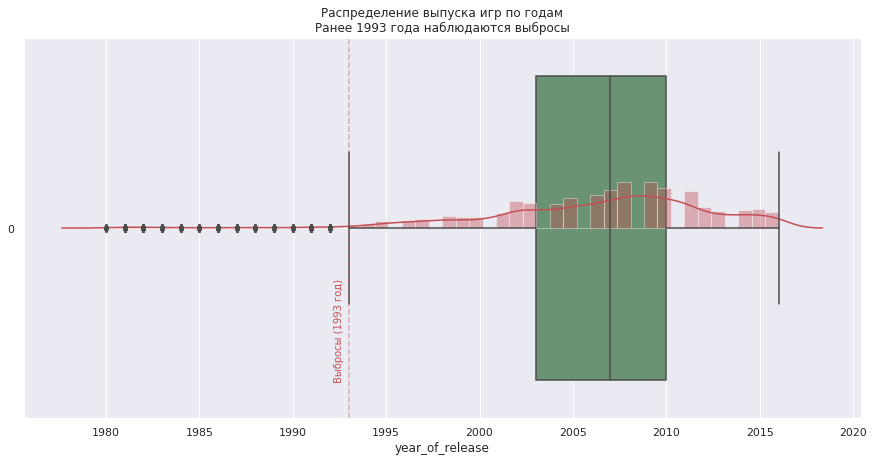

In [44]:
sns.set()
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)


sns.distplot(data.year_of_release, color='r', ax=ax)
sns.boxplot(data=data.year_of_release, orient="h", saturation=0.5, color='g', ax=ax)


plt.axvline(year_of_rel_low_board, color='r', linestyle='dashed', alpha=.4)
plt.title('Распределение выпуска игр по годам\nРанее {} года наблюдаются выбросы'.format(year_of_rel_low_board))

ax.text(year_of_rel_low_board-.5, -.4, str('Выбросы (1993 год)'), color='r', size=10, rotation= 90, ha="center")

ax.invert_yaxis()

plt.show()

Согласно распределению актуальные данные для иследования лежат в промежутке от 1993 до 2016 года, максимальные значения продаж соответствует 2007-2008 годам, далее продажи снижаются

In [45]:
df_games = data[data['year_of_release'] >=1993]

#### Изменение продаж по платформам

In [46]:
def sales_for_platform_by_years(df, legend_cols=4, rot_color=-10, dark_color=0.15):
    #Создадим сводную таблицу
    d = df.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

    #Создадим вспомогательный df для сортировки платформ по годам и отсортируем d
    _d2 = df[['platform', 'year_of_release']].groupby('platform').min().sort_values(by='year_of_release')
    d = d[_d2.index]

    #Зададим параметры осей
    sns.set()
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 7)

    #Создадим график типа bar, накопительный
    d.plot(kind='bar', stacked=True, ax=ax, width=.8, rot=45,
           color=sns.cubehelix_palette(_d2.index.nunique(),rot=rot_color , light=1, dark=dark_color))

    #Добавим подписи осей и изменим легенду
    ax.legend(ncol=legend_cols, loc=0)
    ax.set_ylabel('total_sales')
    ax.set_title('Распределение продаж по годам с разбивкой по платформам')

    plt.show()
    return d

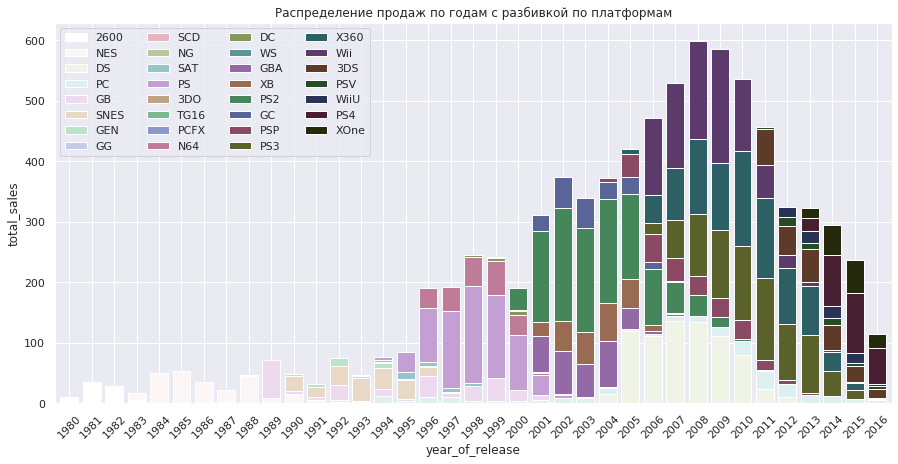

In [47]:
sales_all_period = sales_for_platform_by_years(data, legend_cols=4)

UPD:
Из-за сливающейся гаммы рассмотрим отрезок 2005 - 2016 чуть ближе

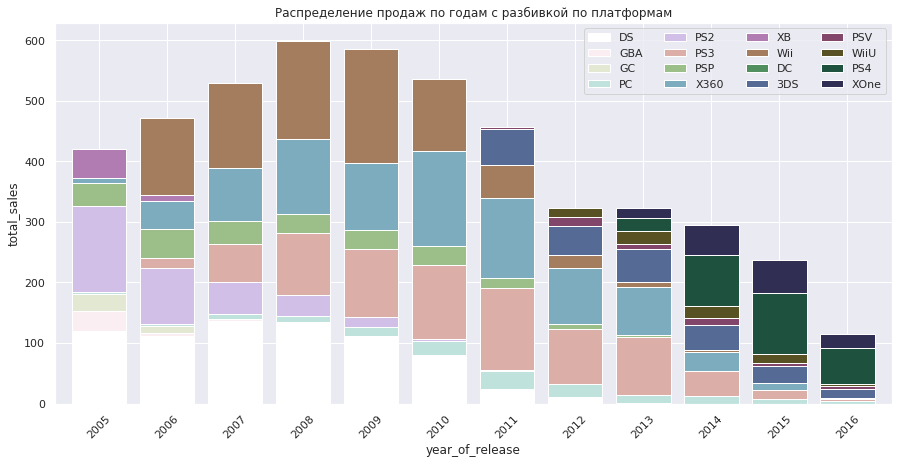

In [48]:
salec_since_2005 = (
    sales_for_platform_by_years(
        data[data.year_of_release >= 2005],
        legend_cols=4, dark_color=.2, rot_color=-5)
)

Проверим общее количество релизов по годам

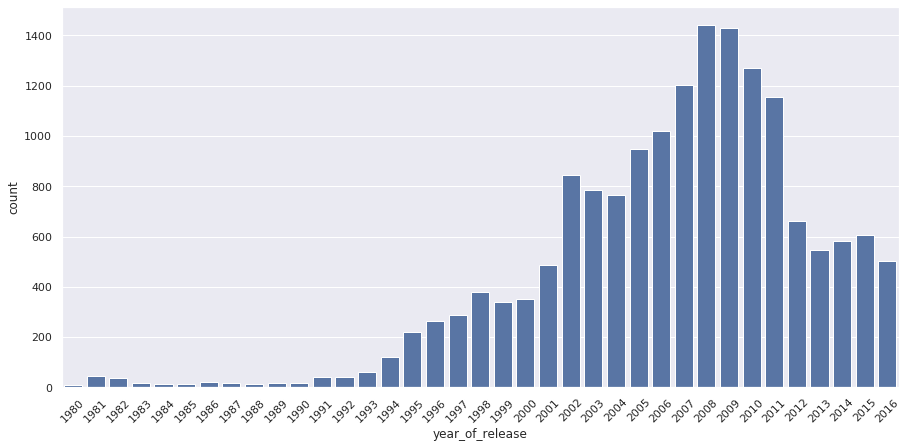

In [49]:
plt.figure(figsize=(15, 7))
sns.countplot(x="year_of_release", data=data, color='b')
plt.xticks(rotation=45)

plt.show()


Из графика наблюдается, что средняя продолжительность существования игровых платформ составляет от 5 до 6-ти лет, некоторые из них достигают до 8 лет, но продажи после 6 лет существования значительно снижаются
Исключение составляет платформа "PC", которой соответствует умеренное количество продаж на протяжении начиная с 1994 года

<h5 style="color:green">Updt:</h5>
На графике можно заметить, что с начиная с 2001 года на рынке активно присутствуют несколько платформ и значительно увеличилось количество продаж, для дальнейшего начала анализа предлагается выбрать период начиная с 2001 и по 2016, в последующем при необходимости скорректируем период

Найдем платформы с топ продажами, обозначим границу топ продаж в качестве 80-го процентиля

In [50]:
#Сгруппируем платформы по общим продажам
_top_sales = (
    data[['platform', 'total_sales']]
    .groupby('platform')
    .sum()
    .sort_values(by='total_sales', ascending=False)
)

#Найдем значение соответствующее 80-му процентилю
_board_for_total_sales = np.percentile(_top_sales.total_sales, 80)

#Отфильтруем по полученному значению
top_sales_by_platform = _top_sales.loc[_top_sales.total_sales > _board_for_total_sales]


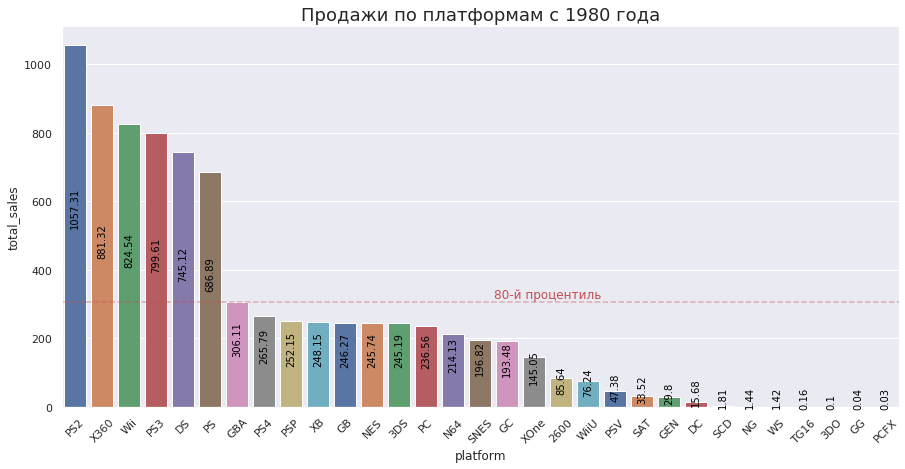

,total_sales
platform,
PS2,"1,057.31"
X360,881.32
Wii,824.54
PS3,799.61
DS,745.12
PS,686.89


In [51]:
sns.set()
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)
    
g = sns.barplot(x=_top_sales.index, y="total_sales", data=_top_sales, palette="deep", ax=ax)
plt.xticks(rotation=45)
plt.title('Продажи по платформам с 1980 года', fontsize=18)

l = plt.axhline(_board_for_total_sales, color='r', linestyle='dashed', alpha=.4)
g.text(len(_top_sales)/2, _board_for_total_sales + 10, str('80-й процентиль'), color='r')


coun = 0
for value in _top_sales.total_sales.to_numpy():
    g.text(coun, (value/2), str(round(value, 2)), color='0', size=10, rotation= 90, ha="center")
    coun += 1


plt.show()
display(top_sales_by_platform)

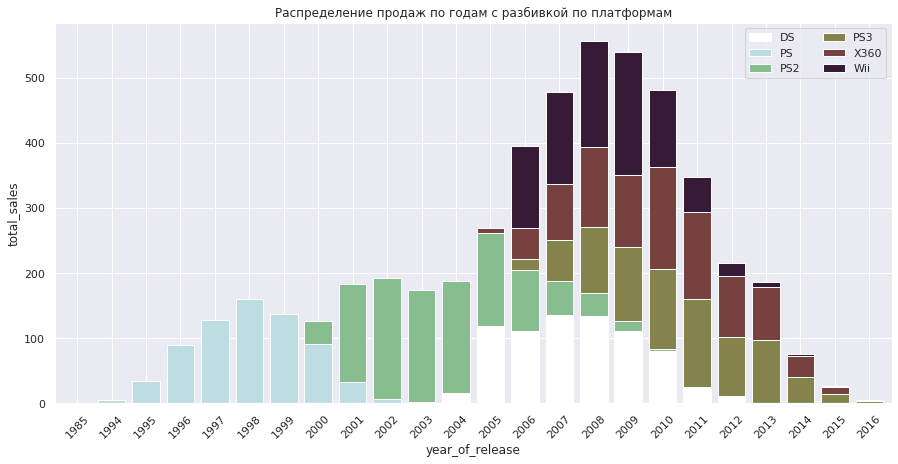

In [52]:
df_with_top_platform = data[data.platform.isin(top_sales_by_platform.index)]

sales_for_top_platform = sales_for_platform_by_years(df_with_top_platform, legend_cols=2, rot_color=1)

Успешные платформы появляются и замещают друг друга только начиная с 2007 года наблюдается нарастание конкуренции между ними - на рынке участвуют все существующие на тот момент платформы.

С 2011 года наблюдается активный спад продаж для этих платформ к 2016 они почти не участвуют на рынке.

Более наглядно представлен жизненый цикл платформ, в среднем период наиболее активных продаж составляет 5 лет, также наблюдается незначительный уровень продаж до активного периода равный ~1 году и 1-2 года продаж с незначительным объемом, после активного периода

### Данные за актуальный период

Т.к. мы определили в качестве актуального периода период начиная с 2001 года, то проверим распределение продаж внутри этого периода и наиболее прибыльные платформы, возможно скорректируем период

Однако исходя из "жизненого цикла" платформ также логично принять в качестве периода данные последних 5-ти лет, и проверить идет ли активный спад по продажам

In [53]:
df_games = data[data.year_of_release >= 2001]

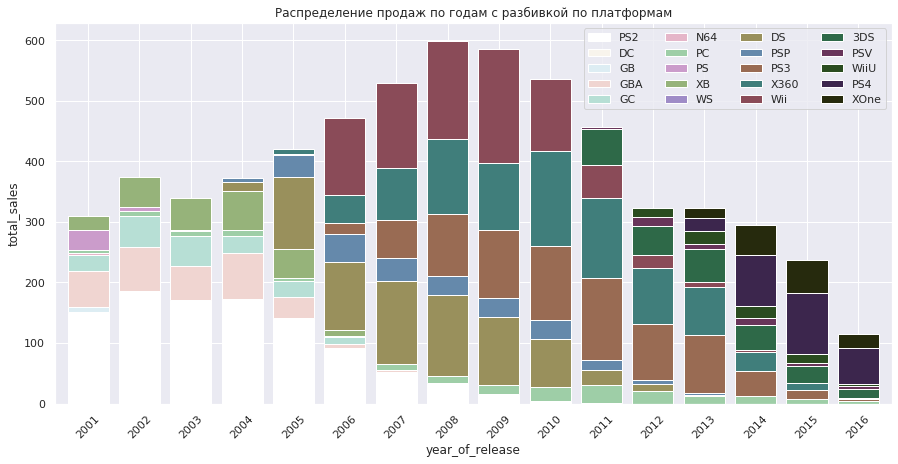

In [54]:
sales_since_2001 = sales_for_platform_by_years(df_games, legend_cols=4, rot_color=-10)

Продажи неумалимо снижаются, рассмотрим более подробно промежуток 2014-2016 год

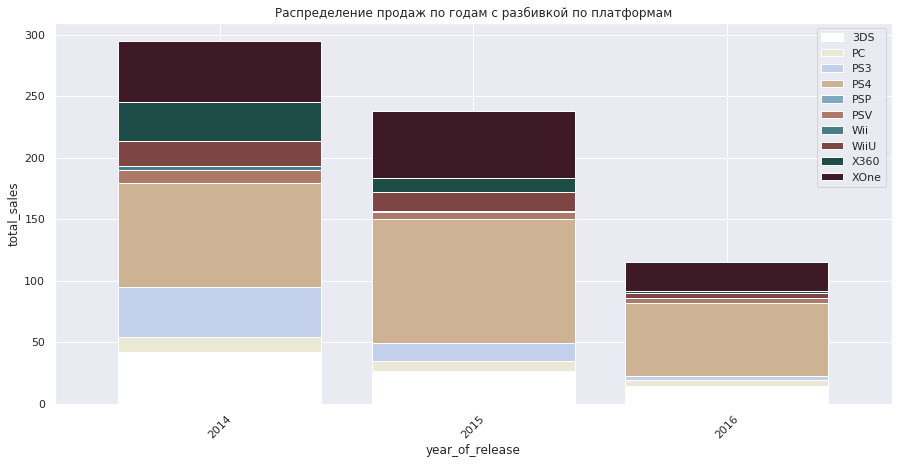

In [55]:
sales_since_2013 = sales_for_platform_by_years(df_games[df_games.year_of_release > 2013],
                                               legend_cols=1, rot_color=-5)

In [56]:
sales_since_2013['total_sales'] = sales_since_2013.sum(axis=1)

На сколько видно, наиболее потенциально прибыльная платформа остается PS4, но так как данные получены из открытых источников, то возможно они не достаточно полные, проверим значения до 2016 года

Проверим изменение продаж с 2010 по 2015 годы

In [57]:
sales_2010_2015 = df_games[(df_games.year_of_release >= 2010) & (df_games.year_of_release <= 2015)]

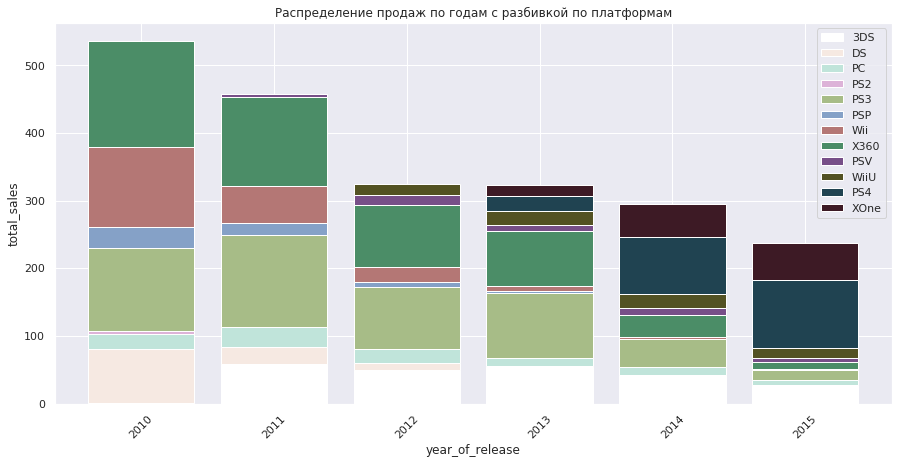

In [58]:
sales_2010_2015 = sales_for_platform_by_years(df_games[(df_games.year_of_release >= 2010)
                                                        & (df_games.year_of_release <= 2015)],
                                               legend_cols=1, rot_color=-5)

In [59]:
sales_2010_2015.style.bar()

platform,3DS,DS,PC,PS2,PS3,PSP,Wii,X360,PSV,WiiU,PS4,XOne
year_of_release,,,,,,,,,,,,
2010,0.280000,79.790000,22.910000,4.440000,122.060000,31.440000,118.410000,156.280000,nan,nan,nan,nan
2011,58.800000,24.440000,29.820000,0.350000,136.210000,16.980000,54.500000,132.420000,4.000000,nan,nan,nan
2012,49.140000,11.010000,20.610000,nan,91.640000,7.760000,21.330000,92.340000,13.650000,16.300000,nan,nan
2013,53.970000,1.420000,11.830000,nan,95.850000,3.340000,7.870000,80.820000,9.140000,20.120000,22.120000,17.210000
2014,41.750000,nan,12.380000,nan,40.880000,0.240000,3.450000,31.610000,10.560000,20.350000,84.220000,49.260000
2015,26.750000,nan,7.930000,nan,14.700000,0.120000,1.050000,10.860000,5.930000,15.220000,100.440000,54.670000


### Данные за актаульный период

In [60]:
data_actual = data[(data.platform.isin(sales_2010_2015.columns))
                       & (data.year_of_release >= 2010)
                       & (data.year_of_release <= 2015)].copy()

**Q**: Какие платформы лидируют по продажам, растут или падают? 

**A**: На графиках видно, что 2008, 2009 годы являются пиковыми как для продаж, так и для количества релизов.
После 2009 года наблюдается заметный спад продаж и релизов. Согласно нашим данным, на момент 2015 - 2016 годов общий объем продаж и релизов достигает только 50% от значений 2008-го года

Лидеры продаж за все время наблюдений являются:
+ топ3 - PS2, X360, Wii
На заключительный момент (2015-2016 года):
+ Примерно половину рынка занимает PS4
+ И значительно меньшую долю рынка XOne и 3DS

**Q**: А есть ли сейчас потенциально прибыльные платформы и кто они?

**A**: Если судить о жизненом цикле платформ (в среднем до 7 лет), то можно заметить 3 этапа:
+ рост продаж (1-2 года) - набирает популярность
+ одна из основных платформ лидеров (от 3 до 6) лет
+ спад продаж (1-2 года) - "производители, пора сделать, что-нибудь новенькое"

В случае если наложить жизненый цикл платформ на платформы начиная с периода 2010 года, то можно заметить:
+ Остаются на плаву только PS4 и XOne
+ вероятнее всего они будут лидерами и в следующих 3-4-х годах
+ при этом наблюдается, что продажи по PS4 превышают XOne почти в 2 раза.
+ Однако для 2016 года наблюдается спад продаж, причем достаточно резкий, будем надеяться, что это всего лишь данные из открытых источников и у этих платформ все будет хорошо😁

Собственно PS4 и XOne имеют наибольший потенциал.

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

Построим для периода начиная с 2010 года

In [61]:
#Создадим таблицу с основными метриками по платформам
for_box_plot_description = pd.Series()
for plat in sales_2010_2015.columns:
    _s = (data[(data.platform == plat)
                & (data.year_of_release >= 2010)
                & (data.year_of_release <= 2015)]['total_sales'].describe()[['min', '25%', '50%', '75%', 'max']]
         )
    for_box_plot_description = pd.concat([for_box_plot_description, _s], axis=1)

for_box_plot_description.drop(columns=[0], inplace=True)

for_box_plot_description.columns = sales_2010_2015.columns

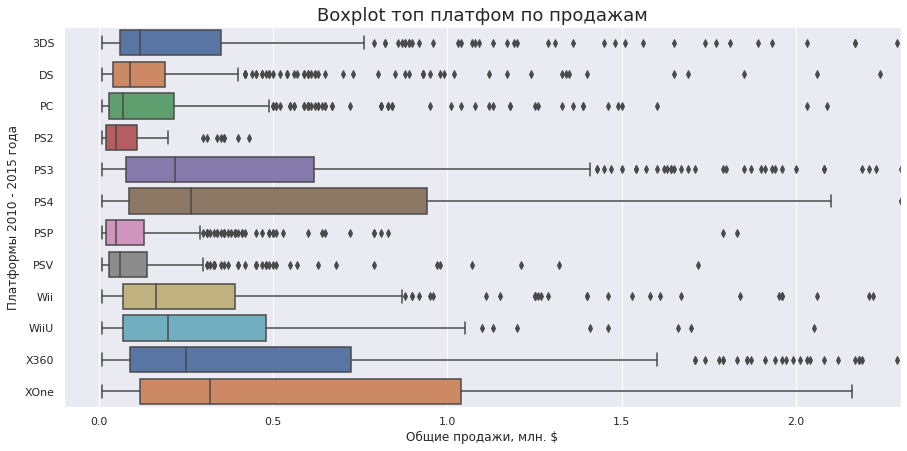

platform,3DS,DS,PC,PS2,PS3,PSP,Wii,X360,PSV,WiiU,PS4,XOne
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.060000,0.040000,0.030000,0.020000,0.080000,0.020000,0.070000,0.090000,0.030000,0.070000,0.087500,0.120000
50%,0.120000,0.090000,0.070000,0.050000,0.220000,0.050000,0.165000,0.250000,0.060000,0.200000,0.265000,0.320000
75%,0.350000,0.190000,0.217500,0.110000,0.617500,0.130000,0.390000,0.725000,0.140000,0.480000,0.942500,1.040000
max,13.820000,14.330000,4.600000,0.430000,17.090000,4.870000,9.060000,20.130000,1.720000,6.580000,12.250000,6.710000


In [62]:


#Оформление
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)

#Нарисуем график
sns.boxplot(x='total_sales', y='platform',
            data=(data_actual.sort_values(by='platform')),
            orient="h",
            palette="deep")

#Найдем лимит по оси Х - в качесте лимита возьмем самый большой 90-й процентиль
_limit = data[data.platform.isin(sales_2010_2015.columns)][['platform', 'total_sales']]\
    .groupby('platform')\
    .quantile(q=.92)\
    .sort_values(by='total_sales', ascending=False)\
    .iloc[0]\
    .values

#Оформление
plt.xlim(-0.1, _limit)
ax.set_ylabel('Платформы 2010 - 2015 года')
ax.set_xlabel('Общие продажи, млн. $')
plt.title('Boxplot топ платфом по продажам', fontsize=18)

plt.show()

display(for_box_plot_description.style.set_caption('Топ платформы 2010-2015 года'))

Из графика можно выделить, что за период 2010 - 2015 годов:
+ наибольший успех (больше всего продается) игр имеют платформы XOne и PS4
+ медианные продажи на этих платформах -  0,32 и 0,265 млн.долл соответственно
+ чуть меньшие продажи показывают их предшествинники X360 и PS3
+ 0,25 и 0,22 млн.долл соответственно
+ Остальные платформы менее прибыльны


P.S. Скорее всего здесь указаны продажи не в млн.долл, а в количиствах проданных экземпляраов игры (иначе при средней стоимости игры на PS4 100 долл, получается, что продается в среднем 2650 экземпляров игр, что очень мало для глобальных продаж)

### Проверим влияние оценки критиков и пользователей на продажи внутри отдной платформы

Для анализа проверим для платформы 'PS2', т.к. она уже прошла свой жизненый цикл и наибольший показатель по продажам

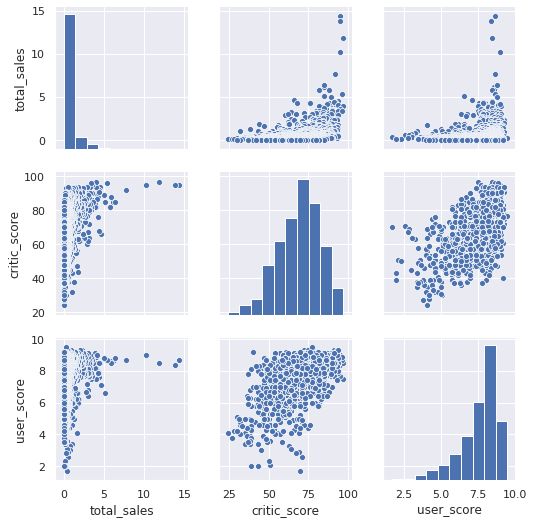

In [63]:
sns.pairplot(data.loc[(data.platform == 'PS2')
                      & data.critic_score.notnull()
                      & data.user_score.notnull(),
                      ['total_sales', 'critic_score', 'user_score']])
plt.show()

Определенно наблюдается некоторая зависимость - лучшей оценке критиков/пользователей соответствует больший объем продаж.

Самым большим продажам соответствуют лучшие оценки критиков и пользователей

Проверим продажи для игр входящих до 95-го процентиля

In [64]:
board_of_norm_sales_PS2 = data.loc[data.platform == 'PS2', 'total_sales'].quantile(.95)
board_of_norm_sales_PS2

2.12

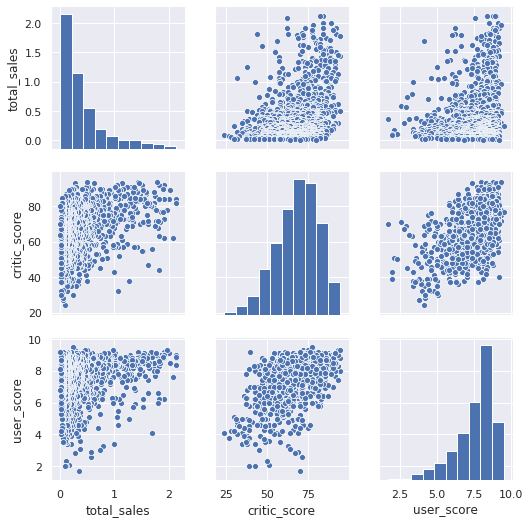

In [65]:
sns.pairplot(
    data.loc[(data.platform == 'PS2')
             & (data.total_sales <= board_of_norm_sales_PS2)
             & data.critic_score.notnull()
             & data.user_score.notnull(),
             ['total_sales', 'critic_score', 'user_score']]
)
plt.show()

Для данных о продажи, исключающих выбросы наблюдается значительно выраженная взаимосвязь с оценкой игры, при чем оценка критиков влияет более сильно, чем оценка пользователей

Построим график отражающий корреляцию этих величин

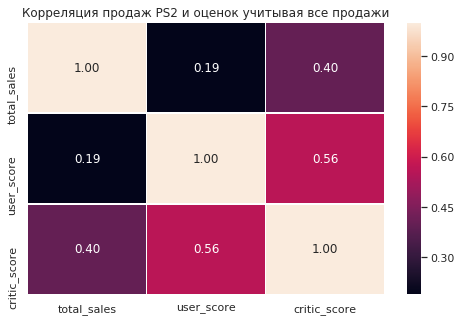

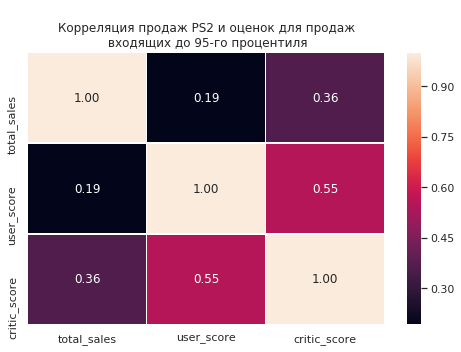

In [66]:
sns.heatmap(data=data.loc[(data.platform == 'PS2')
                          & data.user_score.notnull()
                          & data.critic_score.notnull(),
                          ['total_sales', 'user_score', 'critic_score']].corr(),
            annot=True, fmt='0.2f', linewidths=.5
)
plt.title('Корреляция продаж PS2 и оценок учитывая все продажи')
plt.show()


sns.heatmap(data=(data.loc[(data.platform == 'PS2')
                           & (data.total_sales <= board_of_norm_sales_PS2)
                           & data.user_score.notnull()
                           & data.critic_score.notnull(), 
                           ['total_sales', 'user_score', 'critic_score']]).corr(),
           annot=True, fmt='0.2f', linewidths=.5
)

plt.title('\nКорреляция продаж PS2 и оценок для продаж\n входящих до 95-го процентиля')
plt.show()


Насколько видно из heatmap наблюдается определенная взаимосвязь оценок и продаж, при этом оценка критиков пости в 2 раза весомее чем, оценка пользователей, следовательно выбирая стратегию планирования следует прислушиваться в большей степени к их мнению.

Проверим для текущих лидеров - 'PS4' и 'XOne'

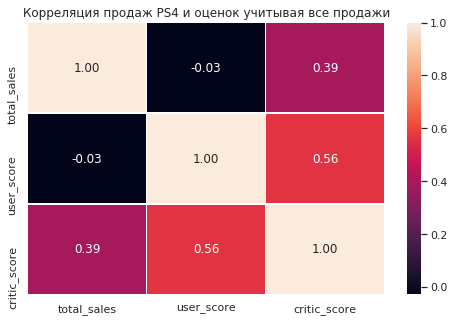

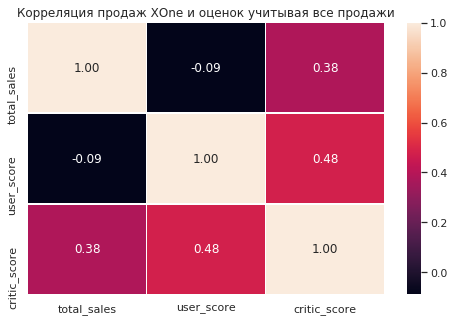

In [67]:
sns.heatmap(data=data.loc[(data.platform == 'PS4')
                          & data.user_score.notnull()
                          & data.critic_score.notnull(),
                          ['total_sales', 'user_score', 'critic_score']].corr(),
            annot=True, fmt='0.2f', linewidths=.5
)

plt.title('Корреляция продаж PS4 и оценок учитывая все продажи')
plt.show()

sns.heatmap(data=data.loc[(data.platform == 'XOne')
                          & data.user_score.notnull()
                          & data.critic_score.notnull(),                         
                          ['total_sales', 'user_score', 'critic_score']].corr(),
            annot=True, fmt='0.2f', linewidths=.5
)


plt.title('Корреляция продаж XOne и оценок учитывая все продажи')
plt.show()

Для сегоднешняго лидера продаж, оценка пользователей практически не влияет на продажи, покупатели все больше стали учитывать мнение критиков при покупке игры

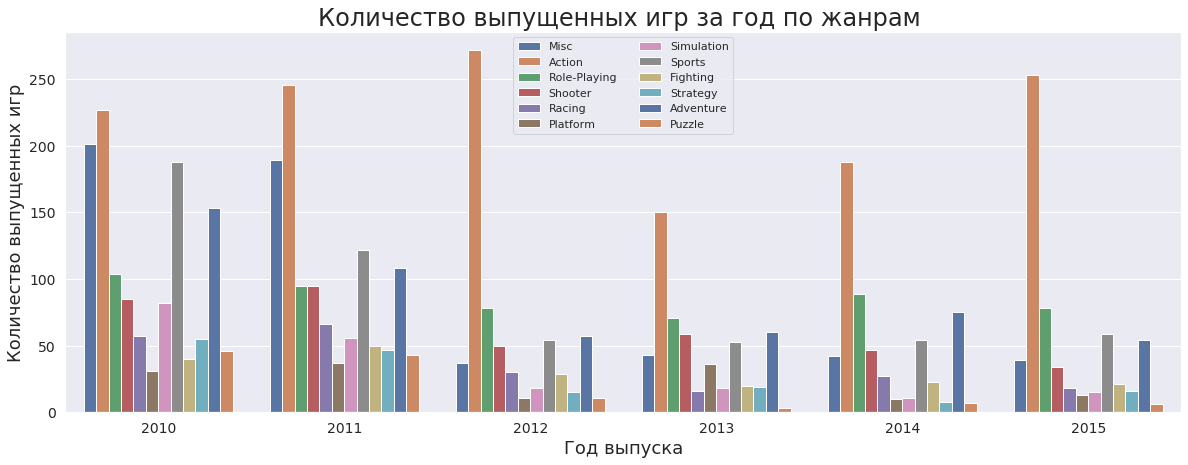

In [68]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 7)

sns.countplot(x="year_of_release",
              data=data_actual, hue='genre',
              order=np.sort(data_actual.year_of_release.unique()), ax=ax,
              palette="deep"
             )

ax.set_xlabel('Год выпуска', fontsize=18)
ax.set_ylabel('Количество выпущенных игр', fontsize=18)
plt.title('Количество выпущенных игр за год по жанрам ', fontsize=24)
ax.legend(ncol=2, loc=0)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

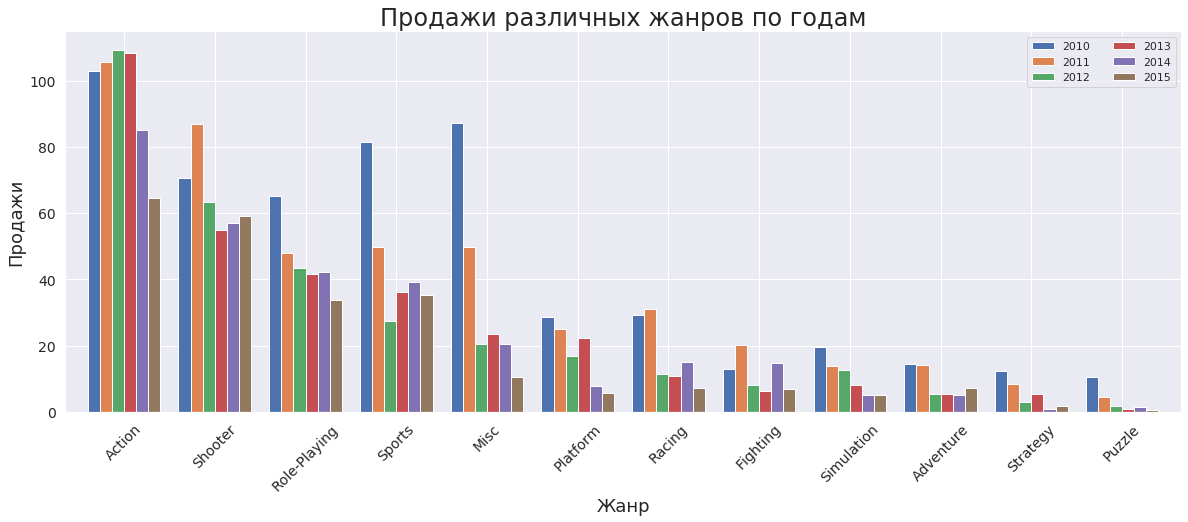

In [69]:
d = data_actual.pivot_table(index='genre', columns='year_of_release', values='total_sales', aggfunc='sum')
d['sum'] = d.loc[ :, 2010 : 2015].sum(axis=1)
d = d.sort_values(by='sum', ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(20, 7)

d.loc[ :, list(range(2010, 2016))].plot(kind='bar', stacked=False, width=.8, rot=45, ax=ax)

plt.title('Продажи различных жанров по годам', fontsize=24)
ax.set_xlabel('Жанр', fontsize=18)
ax.set_ylabel('Продажи', fontsize=18)

ax.legend(list(range(2010, 2016)), ncol=2, loc=0)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

**Q**: Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

**A**: Наиболее прибыльные жанры это Action и Shooter, умеренно прибыльные Rolle-Playing, Sports, остальные жанры менее прибыльны
Важно таже отметить, что количесво Шутеров выпускается гораздо меньше чем Акшн игр, а по прибыльности они уступают совсем не значительно - делаем меньше получаем больше 😎

P.S. Хорошо бы ввести какой-нибудь удельный показатель типа продажи/количество игр и сравнить его, но дедлайн уже близко☹️

## Вывод

1. Согласно распределению гистограммы и boxplot:
 + актуальные данные для иследования лежат в промежутке от 1993 до 2016 года
 + максимальные значения продаж соответствует 2007-2008 годам, далее продажи снижаются
2. Cредняя продолжительность существования игровых платформ составляет от 5 до 6-ти лет, некоторые из них достигают до 8 лет, но продажи после 6 лет существования значительно снижаются Исключение составляет платформа "PC", которой соответствует умеренное количество продаж на протяжении начиная с 1994 года

3. Начиная с 2001 года на рынке активно присутствуют несколько платформ и значительно увеличилось количество продаж.

4. Успешные платформы появляются и замещают друг друга, только начиная с 2007 года наблюдается нарастание конкуренции между ними - на рынке участвуют все существующие на тот момент платформы.

5. С 2011 года наблюдается активный спад продаж для этих платформ к 2016 они почти не участвуют на рынке.

6. Более наглядно представлен жизненый цикл платформ, в среднем период наиболее активных продаж составляет 5 лет, также наблюдается незначительный уровень продаж до активного периода равный ~1 году и 1-2 года продаж с незначительным объемом, после активного периода

7.
Q: Какие платформы лидируют по продажам, растут или падают?

A: На графиках видно, что 2008, 2009 годы являются пиковыми как для продаж, так и для количества релизов. После 2009 года наблюдается заметный спад продаж и релизов. Согласно нашим данным, на момент 2015 - 2016 годов общий объем продаж и релизов достигает только 50% от значений 2008-го года

Лидеры продаж за все время наблюдений являются:

топ3 - PS2, X360, Wii На заключительный момент (2015-2016 года):
Примерно половину рынка занимает PS4
И значительно меньшую долю рынка XOne и 3DS
Q: А есть ли сейчас потенциально прибыльные платформы и кто они?

A: Если судить о жизненом цикле платформ (в среднем до 7 лет), то можно заметить 3 этапа:

рост продаж (1-2 года) - набирает популярность
одна из основных платформ лидеров (от 3 до 6) лет
спад продаж (1-2 года) - "производители, пора сделать, что-нибудь новенькое"
В случае если наложить жизненый цикл платформ на платформы начиная с периода 2010 года, то можно заметить:

Остаются на плаву только PS4 и XOne
вероятнее всего они будут лидерами и в следующих 3-4-х годах
при этом наблюдается, что продажи по PS4 превышают XOne почти в 2 раза.
Однако для 2016 года наблюдается спад продаж, причем достаточно резкий.

Собственно PS4 и XOne имеют наибольший потенциал.

8. Из Boxplot для продаж по платформам можно сделать вывод:
За период 2010 - 2015 годов:

 + наибольший успех (больше всего продается) игр имеют платформы XOne и PS4
 + медианные продажи на этих платформах - 0,32 и 0,265 млн.долл соответственно
 + чуть меньшие продажи показывают их предшествинники X360 и PS3
 + 0,25 и 0,22 млн.долл соответственно
 + Остальные платформы менее прибыльны
 
 
P.S. Скорее всего здесь указаны продажи не в млн.долл, а в количиствах проданных экземпляраов игры (иначе при средней стоимости игры на PS4 100 долл, получается, что продается в среднем 2650 экземпляров игр, что очень мало для глобальных продаж)

9. Наблюдается определенная взаимосвязь оценок и продаж для платформы PS2, при этом оценка критиков пости в 2 раза весомее чем, оценка пользователей, следовательно выбирая стратегию планирования следует прислушиваться в большей степени к их мнению.

10. Для текущих лидеров ( PS4 и XOne) взаимосвязь с оценкой пользователей не сильно заметна, больше оказывает влияние оценка критиков
11. Лучшим оценкам соответствуют лучшие продажи

12. **Q**: Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

**A**: Наиболее прибыльные жанры это Action и Shotter, умеренно прибыльные Rolle-Playing, Sports, остальные жанры менее прибыльны
Важно таже отметить, что количесво Шутеров выпускается гораздо меньше чем Акшн игр, а по прибыльности они уступают совсем не значительно - делаем меньше получаем больше 

# 4. Портрет пользователя каждого региона

### Платформы

In [70]:
def chek_by_region (df, column):
    
    df_pivot = df.pivot_table(index=column,
                   values=['na_sales', 'eu_sales', 'jp_sales', 'total_sales'],
                   aggfunc='sum')

    
    df_NA          = df_pivot.sort_values(by='na_sales', ascending=False).iloc[:5]
    df_NA['ratio'] = df_NA['na_sales'] / df_NA['total_sales']
    
    df_NA.drop(columns=['eu_sales', 'jp_sales', 'total_sales'], inplace=True)


    
    df_EU          = df_pivot.sort_values(by='eu_sales', ascending=False).iloc[:5]
    df_EU['ratio'] = df_EU['eu_sales'] / df_EU['total_sales']
    
    df_EU.drop(columns=['na_sales', 'jp_sales', 'total_sales'], inplace=True)

    

    df_JP          = df_pivot.sort_values(by='jp_sales', ascending=False).iloc[:5]
    df_JP['ratio'] = df_JP['jp_sales'] / df_JP['total_sales']
    
    df_JP.drop(columns=['na_sales', 'eu_sales', 'total_sales'], inplace=True)

    
    display(df_NA.style.set_caption('Топ5 в регионе NA'))
    display(df_EU.style.set_caption('Топ5 в регионе EU'))
    display(df_JP.style.set_caption('Топ5 в регионе JP'))

In [71]:
chek_by_region(data_actual, 'platform')

,na_sales,ratio
platform,,
X360,335.240000,0.664723
PS3,229.800000,0.458372
Wii,122.620000,0.593485
PS4,87.250000,0.421946
3DS,78.970000,0.342321


,eu_sales,ratio
platform,,
PS3,213.480000,0.425819
X360,163.620000,0.324430
PS4,109.310000,0.528629
PC,66.970000,0.634907
Wii,66.240000,0.320604


,jp_sales,ratio
platform,,
3DS,92.590000,0.401361
PS3,58.060000,0.115810
PSP,42.440000,0.708751
DS,27.900000,0.239157
PSV,18.280000,0.422366


Для регионов NA и EU популярные платформы выглядят промерно похожими:
+ первое и второе место делят PS3 и X360, еще раз подтверждая гипотезу о том, что наиболее потенциальными пратформами будут их следующие покаления PS4 и XOne
+ Более половины продаж игр X360 приходится на NA
+ Для EU лидирует по продажам PS3 (доли продаж примерно одинаковые между EU и NA и составляют приблизительно 45%
+ в EU также очень популярен PC, 70% продаж приходится на этот регион

Для JP картина немного другая:
+ в списках также присутствует PS3 (но доля продаж достигает лишь 11%)
+ Очень популярны портативные консоли (что не наблюдается в предыдущих регионах)

### Жанры

In [72]:
chek_by_region(data_actual, 'genre')

,na_sales,ratio
genre,,
Action,284.970000,0.494628
Shooter,222.260000,0.567106
Sports,149.950000,0.556153
Misc,123.160000,0.580423
Role-Playing,106.160000,0.386965


,eu_sales,ratio
genre,,
Action,226.020000,0.392307
Shooter,156.670000,0.399750
Sports,105.080000,0.389734
Role-Playing,71.200000,0.259532
Misc,65.530000,0.308827


,jp_sales,ratio
genre,,
Role-Playing,96.980000,0.353503
Action,65.140000,0.113065
Misc,23.500000,0.110750
Platform,15.700000,0.147806
Sports,14.590000,0.054113


Аналогичная картина и для жанров:
+ в регионах NA и EU популярны одни и тебе жанры, лидеры из них 1-Action, 2-Shooter
+ для региона JP наиболее популярен Role-Playing - сказывается любовь к карманным приставкам
+ Action уверенно занимает лидирующие позиции во всех регионах.


### Рейтинг ESRB

In [73]:
chek_by_region(data_actual, 'rating')

,na_sales,ratio
rating,,
M,379.080000,0.542395
E,269.240000,0.534302
E10+,161.580000,0.586327
T,158.610000,0.507033
EC,1.640000,1.000000


,eu_sales,ratio
rating,,
M,288.820000,0.413249
E,186.960000,0.371019
T,108.800000,0.347804
E10+,100.840000,0.365919
RP,0.030000,1.000000


,jp_sales,ratio
rating,,
E,47.710000,0.094680
T,45.410000,0.145163
M,31.000000,0.044355
E10+,13.160000,0.047754
EC,0.000000,0.000000


Рейтиг ESRB влияет на продажи в регионах, особенное отличие наблюдается в регионе JP доля проданных игр с рейтингом E10+, EC и M на много меньше чем в остальных регионах

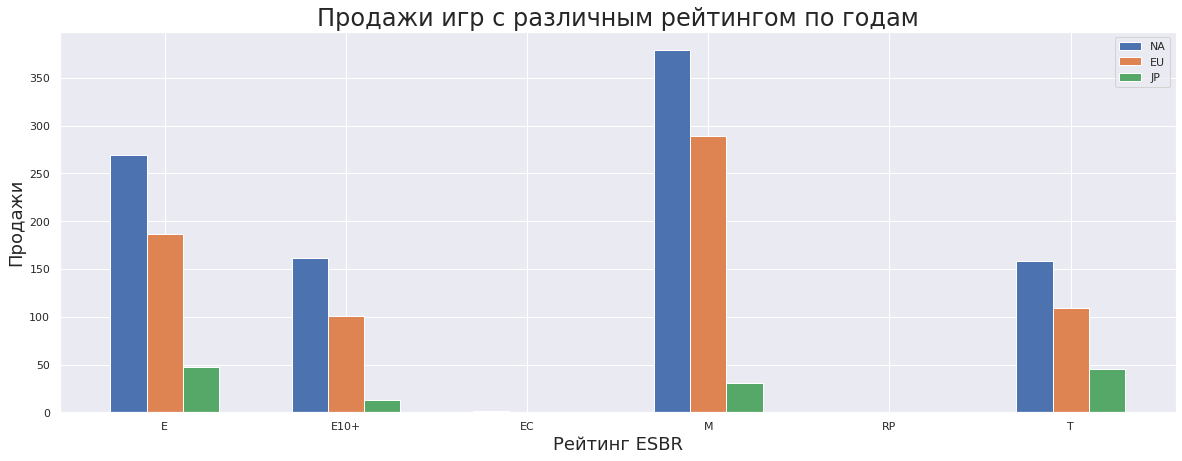

In [74]:
d_na = data_actual.pivot_table(index='rating', values='na_sales', aggfunc='sum')
d_eu = data_actual.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
d_jp = data_actual.pivot_table(index='rating', values='jp_sales', aggfunc='sum')

d_na = d_na.merge(d_eu, left_index=True, right_index=True)
sales_by_reg = d_na.merge(d_jp, left_index=True, right_index=True)

x = np.arange(len(sales_by_reg.index))
width = 0.2

fig, ax = plt.subplots()
fig.set_size_inches(20, 7)

ax.bar(x - width, sales_by_reg['na_sales'], width, label='NA')
ax.bar(x        , sales_by_reg['eu_sales'], width, label='EU')
ax.bar(x + width, sales_by_reg['jp_sales'], width, label='JP')

plt.title('Продажи игр с различным рейтингом по годам', fontsize=24)
ax.legend(['NA', 'EU', 'JP'], ncol=1, loc='upper right')
ax.set_xlabel('Рейтинг ESBR', fontsize=18)
ax.set_ylabel('Продажи', fontsize=18)
ax.set_xticklabels(np.append(0,sales_by_reg.index))


plt.show()




Игры с рейтинго М, которые показывают очень лучшие продажи по миру и в регионах NA и EU, имеют гораздо меньший успех в регионе JP

создадим столбец `best_region_sales` который будет содержать название региона с наибольшим числом продаж по игре

In [75]:
data_actual['best_region_sales'] = 'NA'

data_actual['best_region_sales'].where(data_actual['na_sales'] > data_actual['eu_sales'], 'EU', inplace=True)

data_actual['best_region_sales'].where(data_actual['eu_sales'] > data_actual['jp_sales'], 'JP', inplace=True)

data_actual.loc[(data_actual.na_sales > data_actual.jp_sales)
                & (data_actual.na_sales > data_actual.eu_sales), 'best_region_sales'] = 'NA'

Посмотрим для как распределяется количество выпущенных игр с различным рейтингом, с разбивкой по регионам, в которых наблюдались лучшие продажи 

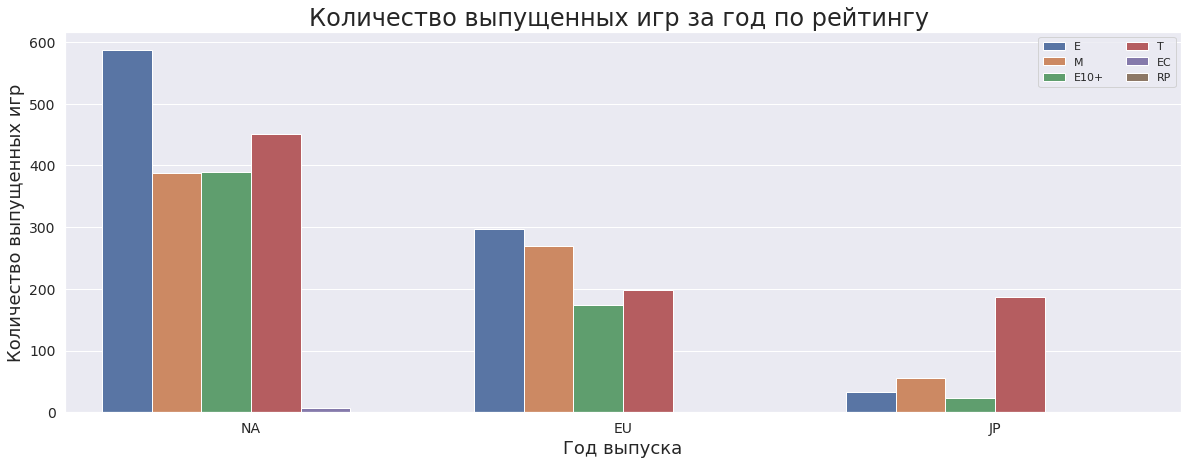

In [76]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 7)

sns.countplot(x="best_region_sales",
              data=data_actual, hue='rating',
              ax=ax,
              palette="deep"
             )

ax.set_xlabel('Год выпуска', fontsize=18)
ax.set_ylabel('Количество выпущенных игр', fontsize=18)
plt.title('Количество выпущенных игр за год по рейтингу ', fontsize=24)
ax.legend(ncol=2, loc='upper right')
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

Для регионов NA и EU в большей степени наблюдается разница в объемах выпущенных игр, которые имели успех по продажам регионе,  то
для региона JP наблюдается преобладание игр с рейтингом T по сравнению с остальными:
+ Регион JP становился глобальным лидером продаж гораздо чаще для игр T, чем для остальных видов рейтинга


## Вывод

1. Для регионов NA и EU популярные платформы выглядят промерно похожими:

первое и второе место делят PS3 и X360, еще раз подтверждая гипотезу о том, что наиболее потенциальными пратформами будут их следующие покаления PS4 и XOne
Более половины продаж игр X360 приходится на NA
Для EU лидирует по продажам PS3 (доли продаж примерно одинаковые между EU и NA и составляют приблизительно 45%
в EU также очень популярен PC, 70% продаж приходится на этот регион
Для JP картина немного другая:

в списках также присутствует PS3 (но доля продаж достигает лишь 11%)
Очень популярны портативные консоли (что не наблюдается в предыдущих регионах)

2. Аналогичная картина и для жанров:

В регионах NA и EU популярны одни и тебе жанры, лидеры из них 1-Action, 2-Shooter
для региона JP наиболее популярен Role-Playing - сказывается любовь к карманным приставкам
Action уверенно занимает лидирующие позиции во всех регионах.

3. Рейтиг ESRB влияет на продажи в регионах, особенное отличие наблюдается в регионе JP доля проданных игр с рейтингом E10+, EC и M на много меньше чем в остальных регионах. Игры с рейтинго М, которые показывают очень лучшие продажи по миру и в регионах NA и EU, имеют гораздо меньший успех в регионе JP

Для регионов NA и EU в большей степени наблюдается разница в объемах выпущенных игр, которые имели успех по продажам регионе, то для региона JP наблюдается преобладание игр с рейтингом T по сравнению с остальными:

Регион JP становился глобальным лидером продаж гораздо чаще для игр T, чем для остальных видов рейтинга


# 5. Проверка гипотезы

## Описание шага

+ Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
+ Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Задайте самостоятельно пороговое значение alpha.

Поясните:
 + Как вы сформулировали нулевую и альтернативную гипотезы;
 + Какой критерий применили для проверки гипотез и почему.

![из яндекса](https://lit-review.ru/wp-content/uploads/2018/04/vibor_stat_kriteria-1024x774.png "Выбор критерия")

## Проверим Гипотезу о равенстве средних рейтингов платформ Xbox One и PC

Создадим 2 сета с рйтингами пользователей XOne и PC
Проверим гипотезу о равенсте средних рейтингов

In [77]:
XOne_user_score = data.loc[(data.platform == 'XOne') & (data.user_score.notnull()), 'user_score']
PC_user_score   = data.loc[(data.platform == 'PC')   & (data.user_score.notnull()), 'user_score']

Проверим распределение

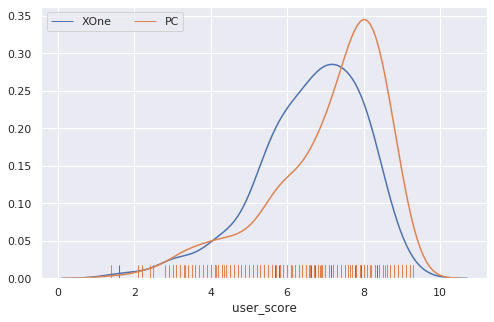

In [78]:
ax = sns.distplot(XOne_user_score, rug=True, hist=False)
sns.distplot(PC_user_score, rug=True, hist=False, ax=ax)

ax.legend(['XOne', 'PC'], ncol=2, loc=0)
plt.show()

Гистограммы скошены влево, 2 независимые группы, выбираем критерий Манна-Уитни

В качестве статестического критерия значимости выберем `alpha = 0.05`

Сформулируем гипотезы:

H0 - Средние пользовательских рейтингов платформ XOne и PC равны;

H1 - Средние пользовательских рейтингов платформ XOne и PC не равны

In [79]:
#Проведем статтест Манна-Уитни
result = st.mannwhitneyu(XOne_user_score, PC_user_score)

#зададим критерий значимости
alpha = .05

print('p-value = ', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
    print('Cредние значения различаются')
        
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value =  7.914570908588745e-08
Отвергаем нулевую гипотезу
Cредние значения различаются


## Проверим Гипотезу о различии средних рейтингов жанров Action и Sports

Создадим 2 сета с рйтингами пользователей XOne и PC
Проверим гипотезу о равенсте средних рейтингов

In [79]:
action_user_score = data.loc[(data.genre == 'Action') & (data.user_score.notnull()), 'user_score']
sports_user_score   = data.loc[(data.genre == 'Sports')   & (data.user_score.notnull()), 'user_score']

Проверим распределение

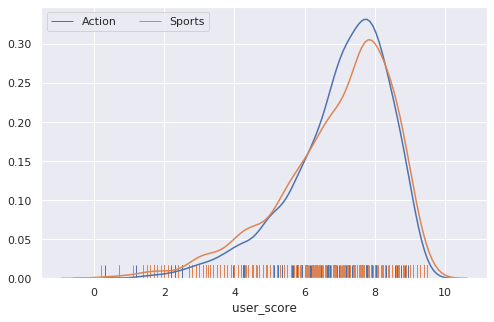

In [80]:
ax = sns.distplot(action_user_score, rug=True, hist=False)
sns.distplot(sports_user_score, rug=True, hist=False, ax=ax)

ax.legend(['Action', 'Sports'], ncol=2, loc=0)
plt.show()

Гистограммы также скошены влево, независимые 2 величины - критерий Манна-Уитни

Сформулируем гипотезы:

H0 - Средние пользовательских рейтингов для жанров Action и Sports равны;

H1 - Средние пользовательских рейтингов для жанров Action и Sports не равны

In [81]:
#Проведем статтест Манна-Уитни
result = st.mannwhitneyu(action_user_score, sports_user_score)

#зададим критерий значимости
alpha = .05

print('p-value = ', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
    print('Cредние значения различаются')
        
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    print('Средние не отличаются')

p-value =  0.3090736907150864
Не получилось отвергнуть нулевую гипотезу
Средние не отличаются


In [82]:
#Проверим еще Т-тестом
# Впринципе для большого набора данных должна работать ЦТП, следовательно можно применять ттест
st.ttest_ind(action_user_score, sports_user_score, equal_var=True) # Pvalue также больше 5%

Ttest_indResult(statistic=1.8034427258333603, pvalue=0.07140681507608147)

## Вывод

1. Проверили 2 гипотезы:
 + О равенстве средних пользовательских рейтингов платформ Xbox One и PC
 + О равенстве средних пользовательских рейтингов жанров Action и Sports
 + В качестве теста для обоих случаев выбрали тест Манна-Уитни, т.к. распределение величин отличается от нормального
 + За критерий статестической значимости выбрали alpha = 5%
2. В качестве результатов получили:
 + Гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC былыа отвергнута
 + Гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports была принята

# Вывод

1. Лидерство среди наиболее популярных платфор в следующем году вероятнее всего будут делить PS4 и XOne
2. Наибольший потенциал по прибыльности остается за жанрами Action и Shooter
3. Менее привликательные жанры Rolle-Playing, Sports, Music
4. Остальные жанры показывают гораздо меньшие продажи
5. При работе с регионом JP стоит учитывать их любовь к портативным консолям 3DS и WiiU, для остальных регионов более популярны полноразмерные консоли
6. А также стоит учитывать лучшую продаваемоть игр рейтинга 'T' в регионе JP, и меньшую успешность игр с рейтингом 'M', похоже основными потребителями игр в данном регионе являются подростки от 13 до 17 лет, для остальных регионов соответствует более широкий возрастной цензор



## Общие выводы

### Обработка данных

На данном этапе мы:
1. Заполнили пропуски используя релевантные данные (использовали среднее значения для тех игр, которым соответствует не значительный разброс значений).
2. Изменили тип данных колонки `user_score` на Int.
3. Перевели значение 'tbd' в Nan, т.к. это неизвестное для нас значение. И частично заполнили его релевантными данными в рамках заполнения пропусков
4. Изменили типы данных для остальных колонок в соответствии с их содержанием

### EDA
1. Согласно распределению гистограммы и boxplot:
 + актуальные данные для иследования лежат в промежутке от 1993 до 2016 года
 + максимальные значения продаж соответствует 2007-2008 годам, далее продажи снижаются
 
 
2. Cредняя продолжительность существования игровых платформ составляет от 5 до 6-ти лет, некоторые из них достигают до 8 лет, но продажи после 6 лет существования значительно снижаются Исключение составляет платформа "PC", которой соответствует умеренное количество продаж на протяжении начиная с 1994 года


3. Начиная с 2001 года на рынке активно присутствуют несколько платформ и значительно увеличилось количество продаж.


4. Успешные платформы появляются и замещают друг друга, только начиная с 2007 года наблюдается нарастание конкуренции между ними - на рынке участвуют все существующие на тот момент платформы.


5. С 2011 года наблюдается активный спад продаж для этих платформ к 2016 они почти не участвуют на рынке.


6. Более наглядно представлен жизненый цикл платформ, в среднем период наиболее активных продаж составляет 5 лет, также наблюдается незначительный уровень продаж до активного периода равный ~1 году и 1-2 года продаж с незначительным объемом, после активного периода

7. Q&A:
 + **Q**: Какие платформы лидируют по продажам, растут или падают?
 + **A**: На графиках видно, что 2008, 2009 годы являются пиковыми как для продаж, так и для количества релизов. После 2009 года наблюдается заметный спад продаж и релизов. Согласно нашим данным, на момент 2015 - 2016 годов общий объем продаж и релизов достигает только 50% от значений 2008-го года

        Лидеры продаж за все время наблюдений являются:

        + топ3 - PS2, X360, Wii На заключительный момент (2015-2016 года):
        + Примерно половину рынка занимает PS4
        + И значительно меньшую долю рынка XOne и 3DS
        
8. Q&A:              
 + **Q**: А есть ли сейчас потенциально прибыльные платформы и кто они?
 + **A**: Если судить о жизненом цикле платформ (в среднем до 7 лет), то можно заметить 3 этапа:

        + рост продаж (1-2 года) - набирает популярность
        + одна из основных платформ лидеров (от 3 до 6) лет
        + спад продаж (1-2 года) - "производители, пора сделать, что-нибудь новенькое"
    
    В случае если наложить жизненый цикл платформ на платформы начиная с периода 2010 года, то можно заметить:

        + Остаются на плаву только PS4 и XOne
        + вероятнее всего они будут лидерами и в следующих 3-4-х годах
        + при этом наблюдается, что продажи по PS4 превышают XOne почти в 2 раза.
        + Однако для 2016 года наблюдается спад продаж, причем достаточно резкий.

    Собственно PS4 и XOne имеют наибольший потенциал.
    

9. Из Boxplot для продаж по платформам можно сделать вывод:
    
    За период 2010 - 2015 годов:

     + наибольший успех (больше всего продается) игр имеют платформы XOne и PS4
     + медианные продажи на этих платформах - 0,32 и 0,265 млн.долл соответственно
     + чуть меньшие продажи показывают их предшествинники X360 и PS3
     + 0,25 и 0,22 млн.долл соответственно
     + Остальные платформы менее прибыльны
 
 
        P.S. Скорее всего здесь указаны продажи не в млн.долл, а в количиствах проданных экземпляраов игры (иначе при средней стоимости игры на PS4 100 долл, получается, что продается в среднем 2650 экземпляров игр, что очень мало для глобальных продаж)

10. Наблюдается определенная взаимосвязь оценок и продаж для платформы PS2, при этом оценка критиков пости в 2 раза весомее чем, оценка пользователей, следовательно выбирая стратегию планирования следует прислушиваться в большей степени к их мнению.


11. Для текущих лидеров ( PS4 и XOne) взаимосвязь с оценкой пользователей не сильно заметна, больше оказывает влияние оценка критиков


12. Лучшим оценкам соответствуют лучшие продажи


13. Q&A:
 + **Q**: Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

 + **A**: Наиболее прибыльные жанры это Action и Shotter, умеренно прибыльные Rolle-Playing, Sports, остальные жанры менее прибыльны
  Важно таже отметить, что количесво Шутеров выпускается гораздо меньше чем Акшн игр, а по прибыльности они уступают совсем не значительно - делаем меньше получаем больше 

### Портрет региона
1. Для регионов NA и EU популярные платформы выглядят промерно похожими:

 + первое и второе место делят PS3 и X360, еще раз подтверждая гипотезу о том, что наиболее потенциальными пратформами будут их следующие покаления PS4 и XOne
 + Более половины продаж игр X360 приходится на NA
 + Для EU лидирует по продажам PS3 (доли продаж примерно одинаковые между EU и NA и составляют приблизительно 45%
 + в EU также очень популярен PC, 70% продаж приходится на этот регион
 

2. Для JP картина немного другая:

 + в списках также присутствует PS3 (но доля продаж достигает лишь 11%)
 + Очень популярны портативные консоли (что не наблюдается в предыдущих регионах)
 

3. Аналогичная картина и для жанров:

 + В регионах NA и EU популярны одни и тебе жанры, лидеры из них 1-Action, 2-Shooter
 + для региона JP наиболее популярен Role-Playing - сказывается любовь к карманным приставкам
 + Action уверенно занимает лидирующие позиции во всех регионах.
 

4. Рейтиг ESRB влияет на продажи в регионах, особенное отличие наблюдается в регионе JP доля проданных игр с рейтингом E10+, EC и M на много меньше чем в остальных регионах. Игры с рейтинго М, которые показывают очень лучшие продажи по миру и в регионах NA и EU, имеют гораздо меньший успех в регионе JP

 + Для регионов NA и EU в большей степени наблюдается разница в объемах выпущенных игр, которые имели успех по продажам регионе, то для региона JP наблюдается преобладание игр с рейтингом T по сравнению с остальными:

 + Регион JP становился глобальным лидером продаж гораздо чаще для игр T, чем для остальных видов рейтинга


### Проверка гипотез
1. Проверили 2 гипотезы:
 + О равенстве средних пользовательских рейтингов платформ Xbox One и PC
 + О равенстве средних пользовательских рейтингов жанров Action и Sports
 + В качестве теста для обоих случаев выбрали тест Манна-Уитни, т.к. распределение величин отличается от нормального
 + За критерий статестической значимости выбрали alpha = 5%
2. В качестве результатов получили:
 + Гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC былыа отвергнута
 + Гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports была принята